# Clusterização Hierárquica

## 1. Introdução

Neste notebook, exploraremos os algoritmos de clusterização hierárquica, uma família de métodos que constrói uma hierarquia de clusters organizando os dados em uma estrutura semelhante a uma árvore. Diferentemente do K-Means, que requer que especifiquemos o número de clusters antecipadamente, a clusterização hierárquica nos permite descobrir a estrutura natural dos dados em diferentes níveis de granularidade.

A clusterização hierárquica pode ser dividida em duas abordagens principais:
- **Aglomerativa (Bottom-up)**: Inicia com cada ponto como um cluster individual e, iterativamente, combina os clusters mais próximos até formar um único cluster.
- **Divisiva (Top-down)**: Inicia com todos os pontos em um único cluster e, recursivamente, divide os clusters até que cada ponto forme seu próprio cluster.

### Conteúdos abordados:

* **Fundamentação Matemática**: Métricas de distância entre clusters e critérios de ligação.
* **Implementação em Python**: Construção do algoritmo aglomerativo passo a passo usando NumPy.
* **Dendrogramas**: Visualização da hierarquia de clusters.
* **Critérios de Ligação**: Single, Complete, Average e Ward.
* **Determinação do Número de Clusters**: Métodos para "cortar" o dendrograma.
* **Aplicações Práticas**: Análise de dados reais e comparação com K-Means.

In [ ]:
# Célula de importação de bibliotecas

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_wine
from scipy.cluster.hierarchy import dendrogram, linkage
import pandas as pd
import seaborn as sns

# Estilo para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 2. Fundamentação Matemática da Clusterização Hierárquica

A clusterização hierárquica aglomerativa funciona com base em uma **matriz de distâncias** entre todos os pares de pontos (ou clusters). O algoritmo segue estes passos fundamentais:

1. **Inicialização**: Cada observação $\mathbf{x}_i$ forma um cluster individual $C_i = \{\mathbf{x}_i\}$.

2. **Cálculo da Matriz de Distâncias**: Para $N$ pontos, calculamos uma matriz simétrica $D \in \mathbb{R}^{N \times N}$ onde $D_{ij}$ representa a distância entre os pontos $\mathbf{x}_i$ e $\mathbf{x}_j$:
   $$ D_{ij} = d(\mathbf{x}_i, \mathbf{x}_j) $$

3. **Iteração**: Em cada passo, encontramos o par de clusters $(C_i, C_j)$ com menor distância e os combinamos em um novo cluster $C_{ij} = C_i \cup C_j$.

4. **Atualização**: Recalculamos as distâncias do novo cluster para todos os outros clusters existentes.

5. **Terminação**: O processo continua até que reste apenas um cluster contendo todas as observações.

### Critérios de Ligação (Linkage)

O ponto crucial da clusterização hierárquica é como definimos a distância entre dois clusters. Existem vários critérios de ligação:

1. **Single Linkage (Ligação Simples)**:
   $$ d(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{y} \in C_j} d(\mathbf{x}, \mathbf{y}) $$
   A distância é definida pelos pontos mais próximos entre os clusters.

2. **Complete Linkage (Ligação Completa)**:
   $$ d(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{y} \in C_j} d(\mathbf{x}, \mathbf{y}) $$
   A distância é definida pelos pontos mais distantes entre os clusters.

3. **Average Linkage (Ligação Média)**:
   $$ d(C_i, C_j) = \frac{1}{|C_i||C_j|} \sum_{\mathbf{x} \in C_i} \sum_{\mathbf{y} \in C_j} d(\mathbf{x}, \mathbf{y}) $$
   A distância é a média de todas as distâncias entre pares de pontos dos clusters.

4. **Ward Linkage (Critério de Ward)**:
   $$d(C_i, C_j) = \frac{|C_i||C_j|}{|C_i|+|C_j|} \|\mathbf{m}_i - \mathbf{m}_j\|^2$$
   Onde $\mathbf{m}_i$ e $\mathbf{m}_j$ são os centróides dos clusters $C_i$ e $C_j$, respectivamente, e $|C_k|$ é o número de pontos no cluster $C_k$.
   Minimiza a variância intra-cluster ao combinar clusters. É baseado na soma dos quadrados das distâncias aos centróides.

## 3. Preparação dos Dados

Vamos começar com um exemplo simples usando dados sintéticos para entender visualmente como funciona a clusterização hierárquica. Depois, aplicaremos o algoritmo ao dataset Iris.

In [ ]:
# Gerando dados sintéticos simples para demonstração
np.random.seed(42)
X_simple = np.array([[1, 2], [1.5, 1.8], [5, 8], [8, 8], [1, 0.6], [9, 11]])

# Visualizar os dados
plt.figure(figsize=(8, 6))
plt.scatter(X_simple[:, 0], X_simple[:, 1], c='blue', s=100, alpha=0.7)
for i, (x, y) in enumerate(X_simple):
    plt.annotate(f'P{i}', (x, y), xytext=(5, 5), textcoords='offset points')
plt.title('Dataset Simples para Demonstração')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

print(f"Coordenadas dos pontos:")
for i, point in enumerate(X_simple):
    print(f"P{i}: {point}")

## 4. Implementação do Algoritmo Hierárquico Aglomerativo

Vamos construir uma implementação simplificada do algoritmo hierárquico aglomerativo para entender seus passos fundamentais.

In [ ]:
class HierarchicalClustering:
    def __init__(self, linkage='single'):
        """
        Inicializa o algoritmo de clusterização hierárquica.
        
        Parameters:
        linkage: str, critério de ligação ('single', 'complete', 'average')
        """
        self.linkage = linkage
        self.merge_history = []
        self.distances = []
        
    def _calculate_distance_matrix(self, X):
        """
        Calcula a matriz de distâncias entre todos os pares de pontos.
        """
        n = len(X)
        dist_matrix = np.zeros((n, n))
        
        for i in range(n):
            for j in range(i+1, n):
                dist = np.linalg.norm(X[i] - X[j])
                dist_matrix[i, j] = dist
                dist_matrix[j, i] = dist
                
        return dist_matrix
    
    def _cluster_distance(self, cluster1, cluster2, X, dist_matrix):
        """
        Calcula a distância entre dois clusters baseado no critério de ligação.
        """
        if self.linkage == 'single':
            # Distância mínima entre qualquer par de pontos dos clusters
            min_dist = float('inf')
            for i in cluster1:
                for j in cluster2:
                    if dist_matrix[i, j] < min_dist:
                        min_dist = dist_matrix[i, j]
            return min_dist
            
        elif self.linkage == 'complete':
            # Distância máxima entre qualquer par de pontos dos clusters
            max_dist = 0
            for i in cluster1:
                for j in cluster2:
                    if dist_matrix[i, j] > max_dist:
                        max_dist = dist_matrix[i, j]
            return max_dist
            
        # elif self.linkage == 'average':
        # Distância média entre todos os pares de pontos dos clusters
        # ...
    
    def fit(self, X):
        """
        Executa o algoritmo de clusterização hierárquica aglomerativa.
        """
        n = len(X)
        
        # Inicializar cada ponto como um cluster
        clusters = [[i] for i in range(n)]
        
        # Calcular matriz de distâncias inicial
        dist_matrix = self._calculate_distance_matrix(X)
        
        self.merge_history = []
        self.distances = []
        
        step = 0
        print(f"Passo inicial: {len(clusters)} clusters individuais")
        print(f"Clusters: {clusters}\n")
        
        # Continuar até que reste apenas um cluster
        while len(clusters) > 1:
            # Encontrar o par de clusters mais próximo
            min_distance = float('inf')
            merge_i, merge_j = -1, -1
            
            for i in range(len(clusters)):
                for j in range(i+1, len(clusters)):
                    distance = self._cluster_distance(clusters[i], clusters[j], X, dist_matrix)
                    if distance < min_distance:
                        min_distance = distance
                        merge_i, merge_j = i, j
            
            # Combinar os clusters mais próximos
            new_cluster = clusters[merge_i] + clusters[merge_j]
            
            # Salvar informações da fusão
            self.merge_history.append((clusters[merge_i].copy(), clusters[merge_j].copy()))
            self.distances.append(min_distance)
            
            step += 1
            print(f"Passo {step}: Combinar clusters {clusters[merge_i]} e {clusters[merge_j]}")
            print(f"Distância: {min_distance:.3f}")
            
            # Remover os clusters antigos e adicionar o novo
            clusters = [clusters[k] for k in range(len(clusters)) if k != merge_i and k != merge_j]
            clusters.append(new_cluster)
            
            print(f"Clusters restantes: {clusters}\n")

## 5. Executando o Algoritmo no Dataset Simples

Vamos aplicar nossa implementação nos dados simples para observar passo a passo como os clusters são formados.

In [ ]:
# Executar a clusterização hierárquica com ligação simples
hc_single = HierarchicalClustering(linkage='single')
hc_single.fit(X_simple)

## 6. Dendrogramas: Visualizando a Hierarquia

Um **dendrograma** é a representação gráfica da hierarquia de clusters. É uma estrutura em forma de árvore que mostra a ordem e as distâncias nas quais os clusters foram combinados.

### Interpretação do Dendrograma:
- **Eixo horizontal**: Representa as observações ou clusters.
- **Eixo vertical**: Representa a distância na qual os clusters foram unidos.
- **Altura dos ramos**: Indica a dissimilaridade entre os clusters combinados.

Vamos usar a implementação otimizada do SciPy para criar dendrogramas profissionais:

### Usando as Funções `linkage` e `fcluster` do SciPy

O SciPy fornece funções otimizadas para clusterização hierárquica que são muito mais eficientes que nossa implementação educacional. As duas funções principais são:

#### 1. Função `linkage(X, method)`

A função `linkage` calcula a matriz de ligação que representa a hierarquia de clusters:

```python
from scipy.cluster.hierarchy import linkage

# Sintaxe básica
linkage_matrix = linkage(X, method='ward')
```

**Parâmetros principais:**
- `X`: matriz de dados (n_samples × n_features)
- `method`: critério de ligação ('single', 'complete', 'average', 'ward')
- `metric`: métrica de distância (padrão: 'euclidean')

**Retorno:**
- Matriz (n-1) × 4 onde cada linha representa uma fusão:
  - Colunas 0 e 1: índices dos clusters sendo combinados
  - Coluna 2: distância da fusão
  - Coluna 3: número de observações no novo cluster

#### 2. Função `fcluster(Z, t, criterion)`

A função `fcluster` extrai clusters da matriz de ligação com base em um critério de corte:

```python
from scipy.cluster.hierarchy import fcluster

# Obter clusters com base na distância
clusters = fcluster(linkage_matrix, t=3.0, criterion='distance')

# Obter um número específico de clusters
clusters = fcluster(linkage_matrix, t=3, criterion='maxclust')
```

**Parâmetros principais:**
- `Z`: matriz de ligação (resultado de `linkage`)
- `t`: valor do critério de corte
- `criterion`: tipo de critério ('distance', 'maxclust', 'inconsistent')

**Critérios de corte:**
- `'distance'`: corta em uma altura específica do dendrograma
- `'maxclust'`: força um número específico de clusters
- `'inconsistent'`: baseado no coeficiente de inconsistência

In [ ]:
# Usando scipy para criar dendrogramas profissionais
# Diferentes critérios de ligação

linkage_methods = ['single', 'complete', 'average', 'ward']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, method in enumerate(linkage_methods):
    # Calcular a matriz de ligação
    linkage_matrix = linkage(X_simple, method=method)
    
    # Criar o dendrograma
    dendrogram(linkage_matrix, ax=axes[i], labels=[f'P{j}' for j in range(len(X_simple))])
    axes[i].set_title(f'Dendrograma - {method.capitalize()} Linkage')
    axes[i].set_xlabel('Pontos de Dados')
    axes[i].set_ylabel('Distância')

plt.tight_layout()
plt.show()

### Comparação dos Critérios de Ligação

Cada critério de ligação produz diferentes estruturas de cluster:

- **Single Linkage**: Tende a criar clusters elongados e pode sofrer do "efeito corrente" (chaining effect).
- **Complete Linkage**: Produz clusters mais compactos e esféricos.
- **Average Linkage**: Um meio-termo entre single e complete.
- **Ward Linkage**: Minimiza a variância intra-cluster, similar ao objetivo do K-Means.

## 7. Determinando o Número de Clusters

Uma das grandes vantagens da clusterização hierárquica é que podemos "cortar" o dendrograma em diferentes alturas para obter diferentes números de clusters. Isso é feito traçando uma linha horizontal através do dendrograma.

In [ ]:
# Usar Ward linkage para o exemplo
linkage_matrix = linkage(X_simple, method='ward')

# Definir diferentes alturas de corte
cut_heights = [2.0, 4.0, 6.0]
colors = ['red', 'green', 'blue']

# Visualizar o dendrograma com diferentes cortes
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=[f'P{j}' for j in range(len(X_simple))])

for height, color in zip(cut_heights, colors):
    plt.axhline(y=height, color=color, linestyle='--', label=f'Corte em {height}')

plt.title('Dendrograma com Linhas de Corte')
plt.xlabel('Pontos de Dados')
plt.ylabel('Distância')
plt.legend()
plt.show()

In [ ]:
# Predição de clusters baseada em diferentes linhas de corte
from scipy.cluster.hierarchy import fcluster

print("Predição de clusters para diferentes alturas de corte:")
print("=" * 55)

for i, height in enumerate(cut_heights):
    # Obter clusters para a altura de corte específica
    clusters = fcluster(linkage_matrix, height, criterion='distance')
    n_clusters = len(np.unique(clusters))
    
    print()
    print(f"Altura de corte: {height}")
    print(f"Número de clusters: {n_clusters}")
    
    # Mostrar quais pontos pertencem a cada cluster
    for cluster_id in np.unique(clusters):
        points = [f"P{j}" for j in range(len(X_simple)) if clusters[j] == cluster_id]
        print(f"  Cluster {cluster_id}: {points}")

In [ ]:
# Visualização dos clusters resultantes
fig, axes = plt.subplots(1, len(cut_heights), figsize=(15, 4))

for i, height in enumerate(cut_heights):
    clusters = fcluster(linkage_matrix, height, criterion='distance')
    scatter = axes[i].scatter(X_simple[:, 0], X_simple[:, 1], c=clusters, s=100, alpha=0.7, cmap='viridis')
    
    # Adicionar rótulos dos pontos
    for j, (x, y) in enumerate(X_simple):
        axes[i].annotate(f'P{j}', (x, y), xytext=(5, 5), textcoords='offset points')
    
    axes[i].set_title(f'Clusters (corte = {height})\n{len(np.unique(clusters))} clusters')
    axes[i].set_xlabel('Feature 1')
    axes[i].set_ylabel('Feature 2')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

## 8. Aplicação ao Dataset Iris

Agora vamos aplicar a clusterização hierárquica ao dataset Iris e comparar os resultados com o K-Means.

In [ ]:
# Carregar o dataset Iris
iris = load_iris()
X_iris = iris.data[:, 2:]  # Usar comprimento e largura da pétala
y_true = iris.target

# Aplicar diferentes métodos de ligação
methods = ['ward', 'complete', 'average', 'single']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, method in enumerate(methods):
    # Calcular a matriz de ligação
    linkage_matrix = linkage(X_iris, method=method)
    
    # Dendrograma
    dendrogram(linkage_matrix, ax=axes[0, i], no_labels=True)
    axes[0, i].set_title(f'Dendrograma - {method.capitalize()}')
    
    # Obter 3 clusters
    clusters = fcluster(linkage_matrix, 3, criterion='maxclust')
    
    # Plotar os clusters
    scatter = axes[1, i].scatter(X_iris[:, 0], X_iris[:, 1], c=clusters, s=50, alpha=0.7, cmap='viridis')
    axes[1, i].set_title(f'Clusters - {method.capitalize()}')
    axes[1, i].set_xlabel('Comprimento da Pétala')
    axes[1, i].set_ylabel('Largura da Pétala')
    
plt.tight_layout()
plt.show()

### Avaliação dos Resultados

Vamos calcular a taxa de acertos para cada método de ligação:

In [ ]:
from scipy.stats import mode

def calculate_purity(y_true, y_pred):
    """
    Calcula a pureza dos clusters comparando com os rótulos verdadeiros.
    """
    correct_predictions = 0
    n_samples = len(y_true)
    
    for cluster_id in np.unique(y_pred):
        mask = (y_pred == cluster_id)
        if np.sum(mask) > 0:
            dominant_label = mode(y_true[mask], keepdims=True)[0][0]
            correct_predictions += np.sum(y_true[mask] == dominant_label)
    
    return correct_predictions / n_samples

print("Comparação dos métodos de ligação no dataset Iris:")
print("="*50)

for method in methods:
    linkage_matrix = linkage(X_iris, method=method)
    clusters = fcluster(linkage_matrix, 3, criterion='maxclust')
    purity = calculate_purity(y_true, clusters)
    print(f"{method.capitalize():12} Linkage: {purity:.1%} de acertos")

### Exercício 1: Implementação do Average Linkage

Complete a implementação da nossa classe `HierarchicalClustering` adicionando o método **Average Linkage**. Em seguida, teste todos os três métodos de ligação (single, complete, average) no dataset simples (`X_simple`) e compare os resultados.

In [ ]:
# Seu código aqui

### Exercício 2: Análise do Dataset Wine - Seleção de Features e Comparação de Métodos

Aplique a clusterização hierárquica do SciPy ao dataset Wine. Primeiro, você deve selecionar um bom par de features para visualização bidimensional, depois comparar diferentes métodos de ligação.

**Tarefas:**
1. Carregue o dataset Wine e explore suas features
2. Selecione as duas melhores features para visualização (analise correlações, variâncias, etc.)
3. Aplique os 4 métodos de ligação ('single', 'complete', 'average', 'ward') usando `scipy.cluster.hierarchy.linkage`
4. Crie dendrogramas para cada método
5. Determine visualmente qual método produz a melhor separação

In [ ]:
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

print("Dataset Wine:")
print(f"Shape: {X_wine.shape}")
print(f"Features: {wine.feature_names}")
print(f"Classes: {wine.target_names}")

# 2. Análise das features para seleção
# Seu código aqui

# 3. Seleção das duas melhores features
# Seu código aqui

# 4. Aplicação dos métodos de ligação e criação dos dendrogramas
# Seu código aqui

# 5. Análise visual e determinação do melhor método
# Seu código aqui

### Exercício 3: Determinação do Número Ótimo de Clusters

Com base no melhor método de ligação identificado no Exercício 2, determine o número ótimo de clusters para o dataset Wine usando análise visual do dendrograma e validação com os rótulos verdadeiros.

**Tarefas:**
1. Use o melhor método identificado no exercício anterior
2. Crie um dendrograma detalhado com linha de corte ajustável
3. Teste diferentes números de clusters (2, 3, 4, 5) usando `fcluster`
4. Para cada número de clusters, visualize os clusters no scatter plot
5. Determine o número ótimo de clusters justificando sua escolha

In [ ]:
# Exercício 3: Determinação do Número Ótimo de Clusters

# 1. Use o melhor método do exercício anterior
# best_method = '...'

# 2. Crie dendrograma com diferentes linhas de corte
# Seu código aqui

# 3. Teste diferentes números de clusters
n_clusters_to_test = [2, 3, 4, 5]

print("Análise do número ótimo de clusters:")
print("=" * 40)

# Seu código aqui

[X_simple] Método: single   | fusões: 5 | últimas distâncias: [3.    3.162 7.12 ]
[X_simple] Método: complete | fusões: 5 | últimas distâncias: [ 3.     5.    13.121]
[X_simple] Método: average  | fusões: 5 | últimas distâncias: [3.    4.081 9.796]


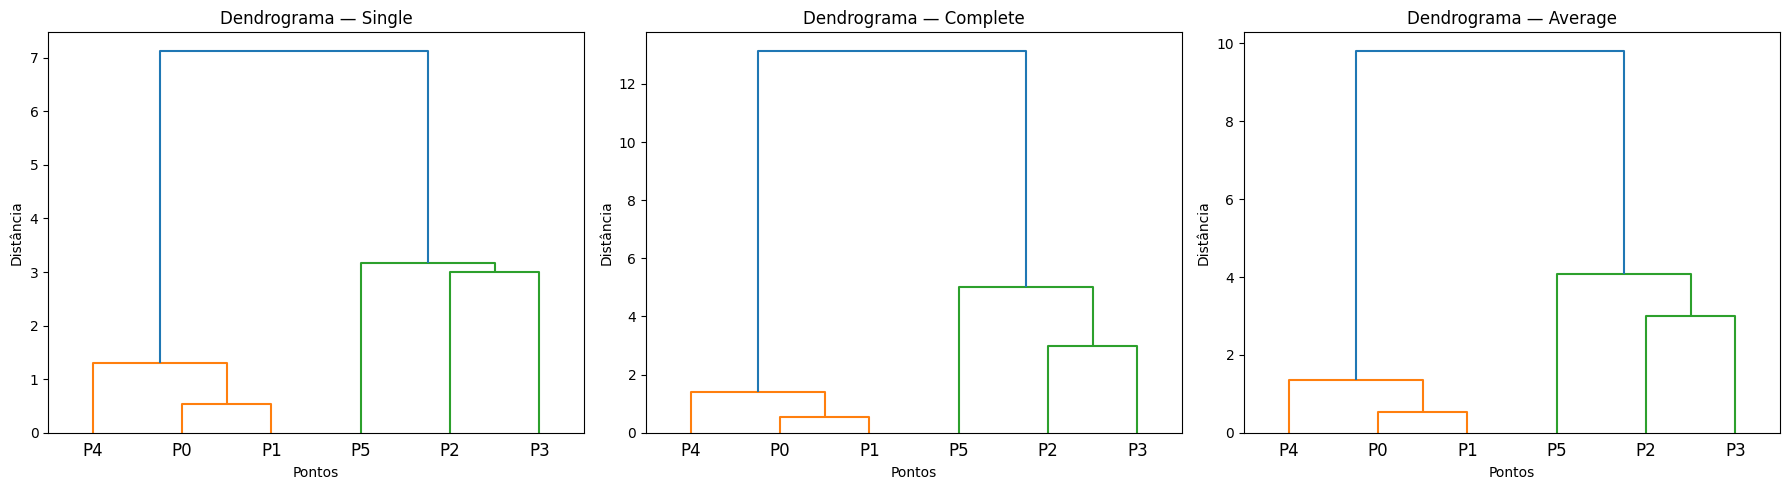

Dataset Wine
Shape: (178, 13)
Features: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Classes: ['class_0', 'class_1', 'class_2']

Top 5 variâncias de features:
proline              99166.717355
magnesium              203.989335
alcalinity_of_ash       11.152686
color_intensity          5.374449
malic_acid               1.248015
dtype: float64

Melhor par (Ward + silhouette com 3 clusters): ('alcohol', 'od280/od315_of_diluted_wines') | silhouette=0.5012


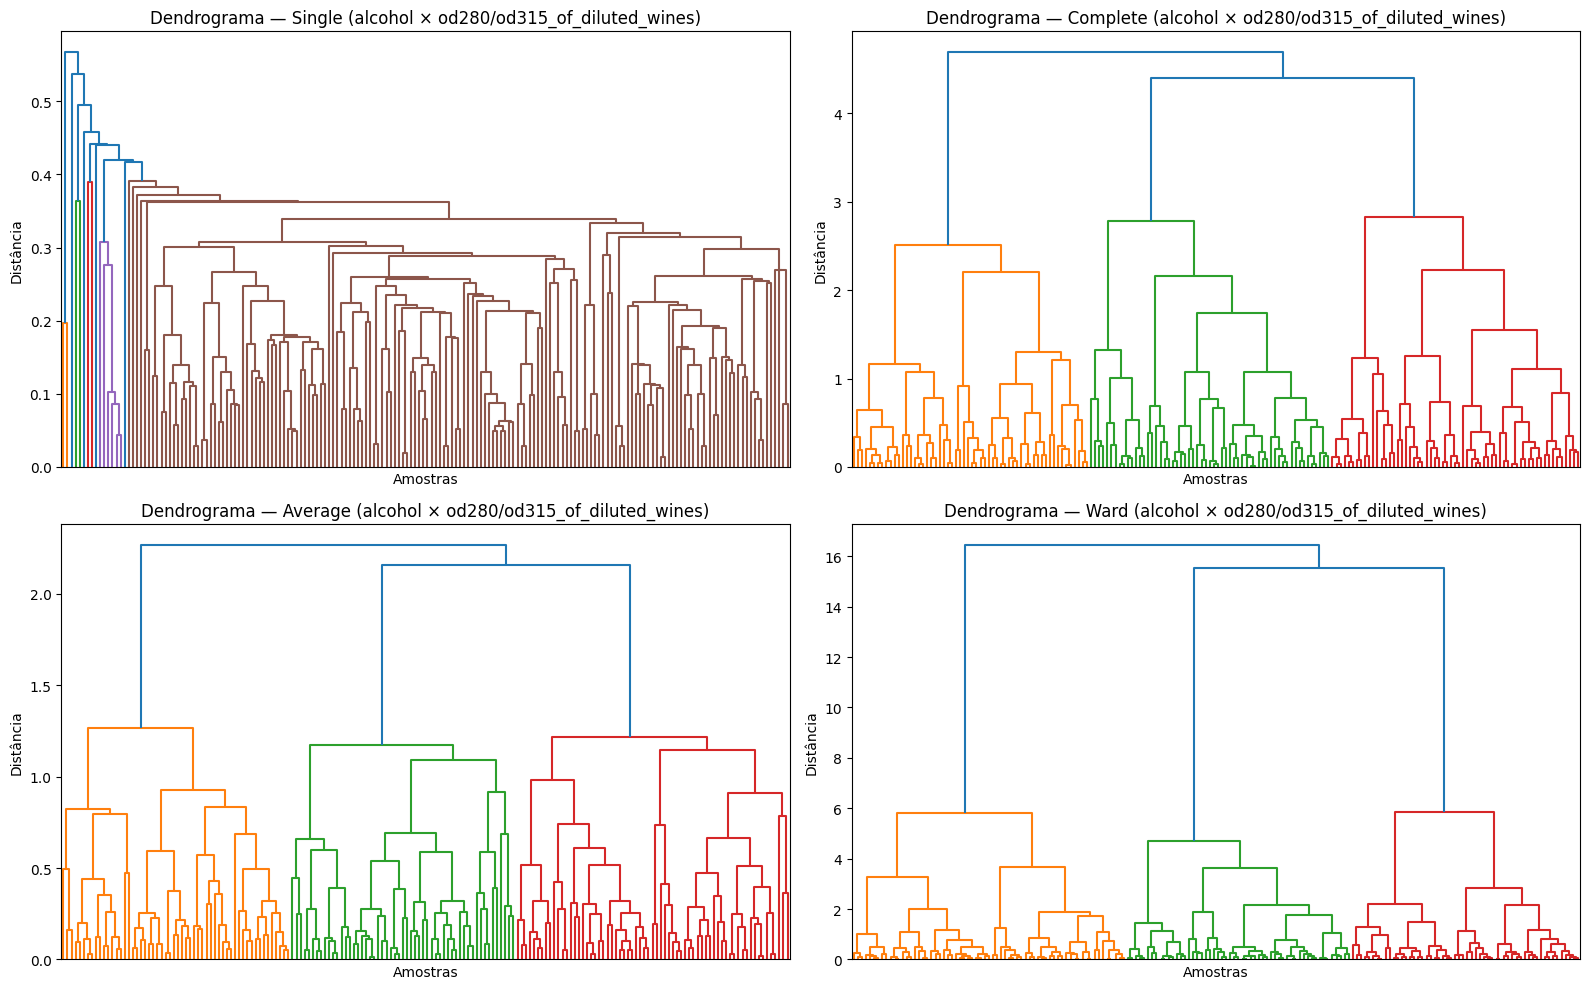

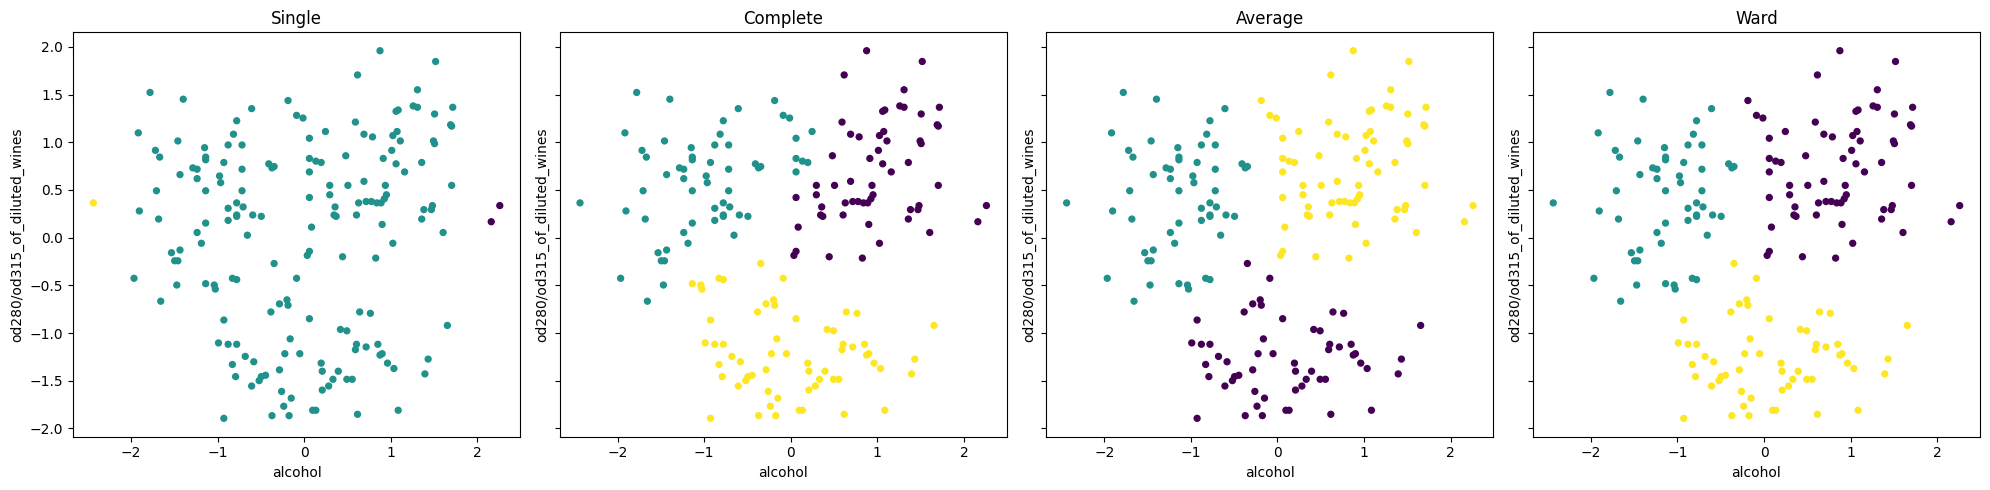


Comparação de métodos (k=3) no par escolhido:
Single   | Silhouette=0.0012 | Pureza=0.4101
Complete | Silhouette=0.4659 | Pureza=0.8596
Average  | Silhouette=0.5012 | Pureza=0.9045
Ward     | Silhouette=0.5012 | Pureza=0.9045

Método sugerido (ranking combinado silhouette+pureza): average


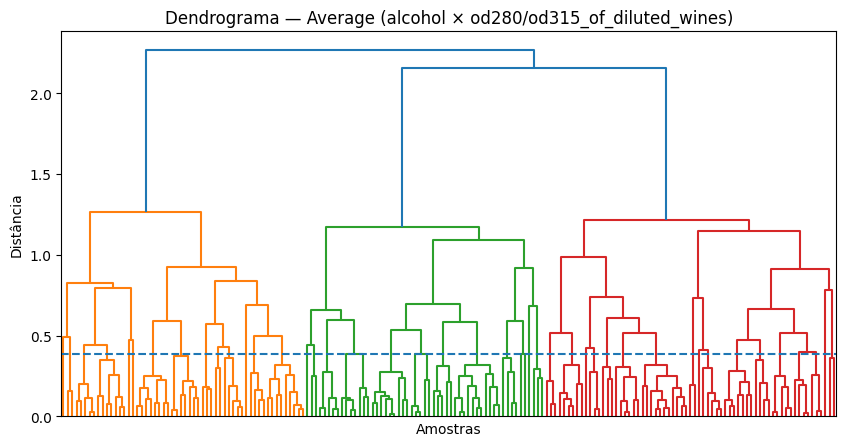


Análise do número ótimo de clusters (método: average )
-------------------------------------------------------
k=2 | Silhouette=0.3795 | Pureza=0.6124
k=3 | Silhouette=0.5012 | Pureza=0.9045
k=4 | Silhouette=0.4369 | Pureza=0.9045
k=5 | Silhouette=0.3790 | Pureza=0.9045


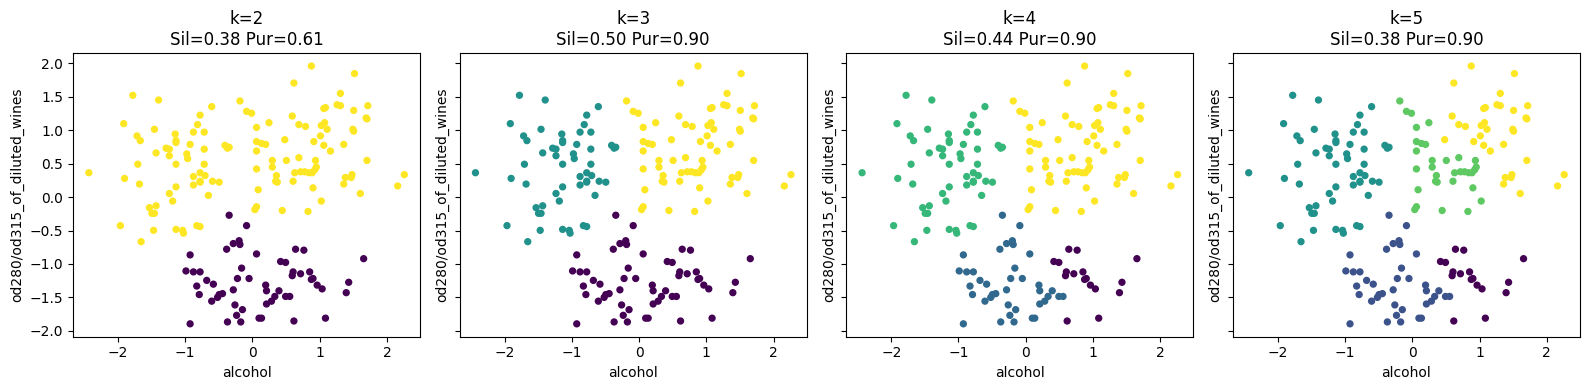


Número ótimo sugerido (ponderando silhouette depois pureza): k=3


In [1]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib scipy scikit-learn --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris, load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from collections import Counter

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import mode

plt.rcParams["figure.figsize"] = (8, 5)

np.random.seed(42)
X_simple = np.array([[1, 2], [1.5, 1.8], [5, 8], [8, 8], [1, 0.6], [9, 11]])

class HierarchicalClustering:
    def __init__(self, linkage='single'):
        self.linkage = linkage
        self.merge_history = []
        self.distances = []

    def _calculate_distance_matrix(self, X):
        n = len(X)
        dist_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i+1, n):
                d = np.linalg.norm(X[i] - X[j])
                dist_matrix[i, j] = d
                dist_matrix[j, i] = d
        return dist_matrix

    def _cluster_distance(self, cluster1, cluster2, X, dist_matrix):
        if self.linkage == 'single':
            return np.min([dist_matrix[i, j] for i in cluster1 for j in cluster2])
        elif self.linkage == 'complete':
            return np.max([dist_matrix[i, j] for i in cluster1 for j in cluster2])
        elif self.linkage == 'average':
            vals = [dist_matrix[i, j] for i in cluster1 for j in cluster2]
            return float(np.mean(vals))
        else:
            raise ValueError("linkage deve ser 'single', 'complete' ou 'average'.")

    def fit(self, X):
        n = len(X)
        clusters = [[i] for i in range(n)]
        dist_matrix = self._calculate_distance_matrix(X)
        self.merge_history, self.distances = [], []
        while len(clusters) > 1:
            min_distance = float('inf')
            merge_i, merge_j = -1, -1
            for i in range(len(clusters)):
                for j in range(i+1, len(clusters)):
                    d = self._cluster_distance(clusters[i], clusters[j], X, dist_matrix)
                    if d < min_distance:
                        min_distance = d
                        merge_i, merge_j = i, j
            new_cluster = clusters[merge_i] + clusters[merge_j]
            self.merge_history.append((clusters[merge_i].copy(), clusters[merge_j].copy()))
            self.distances.append(min_distance)
            clusters = [clusters[k] for k in range(len(clusters)) if k != merge_i and k != merge_j]
            clusters.append(new_cluster)

def run_simple_and_compare():
    methods = ['single', 'complete', 'average']
    for meth in methods:
        hc = HierarchicalClustering(linkage=meth)
        hc.fit(X_simple)
        print(f"[X_simple] Método: {meth:8s} | fusões: {len(hc.merge_history)} | últimas distâncias: {np.round(hc.distances[-3:],3)}")
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for ax, meth in zip(axes, methods):
        Z = linkage(X_simple, method=meth)
        dendrogram(Z, ax=ax, labels=[f'P{j}' for j in range(len(X_simple))])
        ax.set_title(f"Dendrograma — {meth.capitalize()}")
        ax.set_xlabel("Pontos"); ax.set_ylabel("Distância")
    plt.tight_layout(); plt.show()

run_simple_and_compare()

wine = load_wine()
X_wine = wine.data
y_wine = wine.target
feature_names = wine.feature_names
df_wine = pd.DataFrame(X_wine, columns=feature_names)

print("Dataset Wine")
print("Shape:", X_wine.shape)
print("Features:", feature_names)
print("Classes:", wine.target_names.tolist())

var_series = df_wine.var().sort_values(ascending=False)
corr_matrix = df_wine.corr(numeric_only=True)

print("\nTop 5 variâncias de features:")
print(var_series.head())

scaler = StandardScaler()
X_wine_scaled = scaler.fit_transform(X_wine)

def best_pair_by_silhouette(X_scaled, y_true=None, method='ward'):
    n_feat = X_scaled.shape[1]
    best_pair, best_s = None, -1.0
    for i in range(n_feat):
        for j in range(i+1, n_feat):
            X2 = X_scaled[:, [i, j]]
            Z = linkage(X2, method=method)
            labels = fcluster(Z, 3, criterion='maxclust')
            if len(np.unique(labels)) >= 2:
                s = silhouette_score(X2, labels)
                if s > best_s:
                    best_s = s
                    best_pair = (i, j)
    return best_pair, best_s

pair_idx, pair_s = best_pair_by_silhouette(X_wine_scaled, method='ward')
i, j = pair_idx
pair_names = (feature_names[i], feature_names[j])
print(f"\nMelhor par (Ward + silhouette com 3 clusters): {pair_names} | silhouette={pair_s:.4f}")

X2_wine = X_wine_scaled[:, [i, j]]

methods = ['single', 'complete', 'average', 'ward']
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
for ax, meth in zip(axes.ravel(), methods):
    Z = linkage(X2_wine, method=meth)
    dendrogram(Z, ax=ax, no_labels=True)
    ax.set_title(f"Dendrograma — {meth.capitalize()} ({pair_names[0]} × {pair_names[1]})")
    ax.set_xlabel("Amostras"); ax.set_ylabel("Distância")
plt.tight_layout(); plt.show()

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
for ax, meth in zip(axes, methods):
    Z = linkage(X2_wine, method=meth)
    clusters = fcluster(Z, 3, criterion='maxclust')
    ax.scatter(X2_wine[:, 0], X2_wine[:, 1], c=clusters, s=18)
    ax.set_title(meth.capitalize()); ax.set_xlabel(pair_names[0]); ax.set_ylabel(pair_names[1])
plt.tight_layout(); plt.show()

def purity(y_true, y_pred):
    correct = 0
    for c in np.unique(y_pred):
        mask = (y_pred == c)
        if np.any(mask):
            maj = Counter(y_true[mask]).most_common(1)[0][0]
            correct += np.sum(y_true[mask] == maj)
    return correct / len(y_true)

scores = []
for meth in methods:
    Z = linkage(X2_wine, method=meth)
    cl = fcluster(Z, 3, criterion='maxclust')
    sil = silhouette_score(X2_wine, cl) if len(np.unique(cl)) > 1 else -1
    pur = purity(y_wine, cl)
    scores.append((meth, sil, pur))

print("\nComparação de métodos (k=3) no par escolhido:")
for m, sil, pur in scores:
    print(f"{m.capitalize():8s} | Silhouette={sil:.4f} | Pureza={pur:.4f}")

rank_sil = sorted(scores, key=lambda x: x[1], reverse=True)
rank_pur = sorted(scores, key=lambda x: x[2], reverse=True)
rank_sum = {}
for pos, (m, _, _) in enumerate(rank_sil, start=1):
    rank_sum[m] = rank_sum.get(m, 0) + pos
for pos, (m, _, _) in enumerate(rank_pur, start=1):
    rank_sum[m] = rank_sum.get(m, 0) + pos
best_method = min(rank_sum.items(), key=lambda kv: kv[1])[0]
print(f"\nMétodo sugerido (ranking combinado silhouette+pureza): {best_method}")

Z_best = linkage(X2_wine, method=best_method)

plt.figure(figsize=(10, 5))
dendrogram(Z_best, no_labels=True)
plt.title(f"Dendrograma — {best_method.capitalize()} ({pair_names[0]} × {pair_names[1]})")
plt.xlabel("Amostras"); plt.ylabel("Distância")
plt.axhline(y=np.percentile(Z_best[:,2], 75), linestyle='--')
plt.show()

k_list = [2, 3, 4, 5]
print("\nAnálise do número ótimo de clusters (método:", best_method, ")")
print("-"*55)
results_k = []
for k in k_list:
    cl = fcluster(Z_best, k, criterion='maxclust')
    sil = silhouette_score(X2_wine, cl) if len(np.unique(cl)) > 1 else -1
    pur = purity(y_wine, cl)
    results_k.append((k, sil, pur))
    print(f"k={k} | Silhouette={sil:.4f} | Pureza={pur:.4f}")

fig, axes = plt.subplots(1, len(k_list), figsize=(4*len(k_list), 4), sharex=True, sharey=True)
for ax, (k, sil, pur) in zip(axes, results_k):
    cl = fcluster(Z_best, k, criterion='maxclust')
    ax.scatter(X2_wine[:, 0], X2_wine[:, 1], c=cl, s=18)
    ax.set_title(f"k={k}\nSil={sil:.2f} Pur={pur:.2f}")
    ax.set_xlabel(pair_names[0]); ax.set_ylabel(pair_names[1])
plt.tight_layout(); plt.show()

best_k = max(results_k, key=lambda t: (t[1], t[2]))[0]
print(f"\nNúmero ótimo sugerido (ponderando silhouette depois pureza): k={best_k}")


In [ ]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib scipy scikit-learn plotly dtaidistance --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, precision_recall_fscore_support

import plotly.express as px
from dtaidistance import dtw, dtw_distance_matrix

np.random.seed(1)

class DBSCAN:
    def __init__(self, eps=0.5, min_pts=5, metric='euclidean'):
        self.eps = eps
        self.min_pts = min_pts
        self.metric = metric
        self.labels_ = None
        self.core_samples_ = None
        self.n_clusters_ = 0
        self._precomputed = None

    def set_precomputed(self, D):
        self._precomputed = D

    def _calculate_distance_matrix(self, X):
        if self.metric == 'euclidean':
            return np.linalg.norm(X[:, np.newaxis] - X, axis=2)
        elif self.metric == 'radial':
            r = np.linalg.norm(X, axis=1)
            return np.abs(r[:, None] - r[None, :])
        elif self.metric == 'precomputed':
            if self._precomputed is None:
                raise ValueError("distância precomputada ausente")
            return self._precomputed
        else:
            raise ValueError("métrica inválida")

    def _get_neighbors(self, idx, D):
        return np.where(D[idx] <= self.eps)[0]

    def _expand_cluster(self, idx, neigh, cid, D, visited, labels):
        labels[idx] = cid
        q = neigh.tolist()
        while q:
            j = q.pop()
            if not visited[j]:
                visited[j] = True
                neigh_j = self._get_neighbors(j, D)
                if len(neigh_j) >= self.min_pts:
                    q.extend(neigh_j)
            if labels[j] == -1:
                labels[j] = cid

    def fit(self, X=None):
        if self.metric == 'precomputed':
            if self._precomputed is None:
                raise ValueError("forneça matriz de distância")
            n = self._precomputed.shape[0]
            D = self._precomputed
        else:
            if X is None:
                raise ValueError("forneça X quando não for precomputed")
            n = len(X)
            D = self._calculate_distance_matrix(X)
        visited = np.zeros(n, dtype=bool)
        labels = np.full(n, -1)
        core_samples = []
        cid = 0
        for i in range(n):
            if visited[i]:
                continue
            visited[i] = True
            neigh = self._get_neighbors(i, D)
            if len(neigh) >= self.min_pts:
                core_samples.append(i)
                self._expand_cluster(i, neigh, cid, D, visited, labels)
                cid += 1
        self.labels_ = labels
        self.core_samples_ = np.array(core_samples)
        self.n_clusters_ = len(np.unique(labels[labels != -1]))
        return self

    def fit_predict(self, X=None):
        self.fit(X)
        return self.labels_

def k_distance(X, k, metric='euclidean', precomputed=None):
    if metric == 'euclidean':
        nn = NearestNeighbors(n_neighbors=k+1, metric='euclidean').fit(X)
        d, _ = nn.kneighbors(X)
        kth = d[:, k]
    elif metric == 'radial':
        r = np.linalg.norm(X, axis=1)[:, None]
        nn = NearestNeighbors(n_neighbors=k+1, metric='euclidean').fit(r)
        d, _ = nn.kneighbors(r)
        kth = d[:, k]
    elif metric == 'precomputed':
        if precomputed is None:
            raise ValueError("precomputed requerido")
        D = precomputed
        idx = np.arange(D.shape[0])
        sortd = np.sort(D, axis=1)
        kth = sortd[:, k]
    else:
        raise ValueError("métrica inválida")
    return np.sort(kth)

def generate_concentric_spheres(radii=[3, 8, 12], n_samples_per_sphere=200, noise=0.4, random_state=42):
    rng = np.random.default_rng(random_state)
    X, y = [], []
    for i, r in enumerate(radii):
        phi = rng.uniform(0, 2*np.pi, n_samples_per_sphere)
        costheta = rng.uniform(-1, 1, n_samples_per_sphere)
        theta = np.arccos(costheta)
        rr = r + noise * rng.standard_normal(n_samples_per_sphere)
        x = rr * np.sin(theta) * np.cos(phi)
        y_ = rr * np.sin(theta) * np.sin(phi)
        z = rr * np.cos(theta)
        X.append(np.vstack((x, y_, z)).T)
        y.append(np.full(n_samples_per_sphere, i))
    X = np.vstack(X)
    y = np.concatenate(y)
    return X, y

X_spheres, y_spheres = generate_concentric_spheres()
scaler = StandardScaler()
X_spheres = scaler.fit_transform(X_spheres)

fig = px.scatter_3d(x=X_spheres[:,0], y=X_spheres[:,1], z=X_spheres[:,2])
fig.update_traces(marker=dict(size=3))
fig.show()

minpts_list = [5, 10, 15]
for mp in minpts_list:
    kd = k_distance(X_spheres, k=mp-1, metric='euclidean')
    plt.figure(); plt.plot(np.arange(len(kd)), kd); plt.title(f'K-Distance euclidiana (k={mp-1})'); plt.tight_layout(); plt.show()

def select_params_dbscan_euclid(X, target_k=3, minpts_list=[5,10,15]):
    best = None
    for mp in minpts_list:
        kd = k_distance(X, k=mp-1, metric='euclidean')
        eps_candidates = np.linspace(np.percentile(kd, 60), np.percentile(kd, 90), 6)
        for eps in eps_candidates:
            model = DBSCAN(eps=eps, min_pts=mp, metric='euclidean').fit(X)
            labels = model.labels_
            ncl = len(np.unique(labels[labels!=-1]))
            noise_frac = np.mean(labels==-1)
            valid = ncl >= 1
            score = -abs(ncl - target_k) - noise_frac
            if valid and (best is None or score > best[0]):
                best = (score, eps, mp, ncl, noise_frac, labels, model.core_samples_)
    return best

best_e = select_params_dbscan_euclid(X_spheres)
best_score, best_eps, best_minpts, best_ncl, best_noise, labels_e, cores_e = best_e

fig = px.scatter_3d(x=X_spheres[:,0], y=X_spheres[:,1], z=X_spheres[:,2], color=pd.Series(labels_e, dtype=str))
fig.update_traces(marker=dict(size=3))
fig.show()

for mp in minpts_list:
    kd_r = k_distance(X_spheres, k=mp-1, metric='radial')
    plt.figure(); plt.plot(np.arange(len(kd_r)), kd_r); plt.title(f'K-Distance radial (k={mp-1})'); plt.tight_layout(); plt.show()

def select_params_dbscan_radial(X, target_k=3, minpts_list=[5,10,15]):
    best = None
    for mp in minpts_list:
        kd = k_distance(X, k=mp-1, metric='radial')
        eps_candidates = np.linspace(np.percentile(kd, 60), np.percentile(kd, 90), 6)
        for eps in eps_candidates:
            model = DBSCAN(eps=eps, min_pts=mp, metric='radial').fit(X)
            labels = model.labels_
            ncl = len(np.unique(labels[labels!=-1]))
            noise_frac = np.mean(labels==-1)
            valid = ncl >= 1
            score = -abs(ncl - target_k) - noise_frac
            if valid and (best is None or score > best[0]):
                best = (score, eps, mp, ncl, noise_frac, labels, model.core_samples_)
    return best

best_r = select_params_dbscan_radial(X_spheres)
_, best_eps_r, best_minpts_r, best_ncl_r, best_noise_r, labels_r, cores_r = best_r

fig = px.scatter_3d(x=X_spheres[:,0], y=X_spheres[:,1], z=X_spheres[:,2], color=pd.Series(labels_r, dtype=str))
fig.update_traces(marker=dict(size=3))
fig.show()

print("Euclidiano:", {"eps": round(best_eps,4), "min_pts": best_minpts, "clusters": best_ncl, "noise_frac": round(best_noise,3)})
print("Radial:", {"eps": round(best_eps_r,4), "min_pts": best_minpts_r, "clusters": best_ncl_r, "noise_frac": round(best_noise_r,3)})

def generate_time_series_dataset(n_series=50, length=100, noise=0.1, n_outliers=2, random_state=42):
    rng = np.random.default_rng(random_state)
    X, y = [], []
    t = np.linspace(0, 4*np.pi, length)
    for _ in range(n_series):
        amp = rng.uniform(0.8, 1.2)
        freq = rng.uniform(0.9, 1.1)
        phase = rng.uniform(0, 0.5*np.pi)
        series = amp * np.sin(freq * t + phase) + noise * rng.normal(size=length)
        X.append(series)
        y.append(0)
    for _ in range(n_outliers):
        amp = rng.uniform(1.5, 2.0)
        freq = rng.uniform(1.2, 1.5)
        series = amp * np.sin(freq * t) + noise * rng.normal(size=length)
        if rng.random() < 0.5:
            series[length//2] += 3
        else:
            series += rng.normal(2.0, 0.5)
        X.append(series)
        y.append(-1)
    return np.array(X), np.array(y)

X_series, y_series = generate_time_series_dataset()

plt.figure(figsize=(10,4))
for i in range(5):
    plt.plot(X_series[i], alpha=0.7)
for i in range(-3,0):
    plt.plot(X_series[i], alpha=0.7, color="red")
plt.title("Séries temporais (amostras)"); plt.tight_layout(); plt.show()

def dtw_distance_matrix_fast(X):
    n = len(X)
    D = np.zeros((n,n), dtype=float)
    for i in range(n):
        for j in range(i+1, n):
            d = dtw.distance_fast(X[i], X[j])
            D[i,j] = D[j,i] = d
    return D

D_dtw = dtw_distance_matrix_fast(X_series)

for mp in [3,5,8]:
    kd_d = k_distance(None, k=mp-1, metric='precomputed', precomputed=D_dtw)
    plt.figure(); plt.plot(np.arange(len(kd_d)), kd_d); plt.title(f'K-Distance DTW (k={mp-1})'); plt.tight_layout(); plt.show()

def grid_dbscan_dtw(D, y_true, minpts_list=[3,5,8]):
    best = None
    n = D.shape[0]
    for mp in minpts_list:
        kd = k_distance(None, k=mp-1, metric='precomputed', precomputed=D)
        eps_list = np.linspace(np.percentile(kd, 60), np.percentile(kd, 90), 6)
        for eps in eps_list:
            model = DBSCAN(eps=eps, min_pts=mp, metric='precomputed')
            model.set_precomputed(D)
            model.fit()
            labels = model.labels_
            y_pred_anom = (labels == -1).astype(int)
            y_true_anom = (y_true == -1).astype(int)
            p, r, f1, _ = precision_recall_fscore_support(y_true_anom, y_pred_anom, average='binary', zero_division=0)
            score = f1
            if best is None or score > best[0]:
                best = (score, eps, mp, p, r, f1, labels)
    return best

best_dtw = grid_dbscan_dtw(D_dtw, y_series)
_, eps_dtw, mp_dtw, p_dtw, r_dtw, f1_dtw, labels_dtw = best_dtw
print({"eps": round(eps_dtw,4), "min_pts": mp_dtw, "precision": round(p_dtw,3), "recall": round(r_dtw,3), "f1": round(f1_dtw,3)})

plt.figure(figsize=(10,4))
for i, s in enumerate(X_series):
    c = "red" if labels_dtw[i] == -1 else "C0"
    plt.plot(s, color=c, alpha=0.7)
plt.title("Detecção de anomalias com DBSCAN+DTW"); plt.tight_layout(); plt.show()
